<a href="https://colab.research.google.com/github/maneeha/KGLLM/blob/main/1_LLM_with_Knowledge_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Answering questions with knowledge graph vs text-based context in ChatGPT
- Created by John Tan Chong Min
- 7 Aug 2023

- If knowledge graph is extracted correctly, it will actually be better than using the context as it can help to extract out the relevant bits
- However, if the knowledge graph is extracted wrongly, it can lose content
- LangChain implementation of knowledge graph parsing is not ideal
- I provide how I think it should be done using the Strict JSON Framework
- https://github.com/tanchongmin/strictjson

# Approach 1: Without Knowledge Graph and Context

In [ ]:
my_key = ''

In [ ]:
!pip install -q openai langchain

In [ ]:
!pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.16.2
    Uninstalling openai-1.16.2:
      Successfully uninstalled openai-1.16.2


In [ ]:
import re
import os
import json
import openai

import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
os.environ["OPENAI_API_KEY"] = my_key
openai.api_key = my_key

question = "When did apple announce the MacNCheese Pro?"
completion = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                          temperature=0,
                                          messages=[{"role": "user",
                                                     "content": question}])
print(completion["choices"][0]["message"]["content"])

I'm sorry, but there is no record of Apple announcing a product called the MacNCheese Pro. It is possible that this product does not exist or that it was announced by a different company.


# Approach 2: Using Knowledge Graph only (LangChain Graph QA)

## Prompt Format to get the triples

### Step 1: Generate triplets from context
https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/indexes/prompts/knowledge_triplet_extraction.py

https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/indexes/graph.py

You are a networked intelligence helping a human track knowledge triples about all relevant people, things, concepts, etc. and integrating them with your knowledge stored within your weights as well as that stored in a knowledge graph.
Extract all of the knowledge triples from the text.
A knowledge triple is a clause that contains a subject, a predicate, and an object.
The subject is the entity being described, the predicate is the property of the subject that is being described, and the object is the value of the property.

EXAMPLE
It's a state in the US. It's also the number 1 producer of gold in the US.
Output: (Nevada, is a, state), (Nevada, is in, US), (Nevada, is the number 1 producer of, gold)
END OF EXAMPLE

EXAMPLE
I'm going to the store.
Output: NONE
END OF EXAMPLE

EXAMPLE
Oh huh. I know Descartes likes to drive antique scooters and play the mandolin.
Output: (Descartes, likes to drive, antique scooters),(Descartes, plays, mandolin)
END OF EXAMPLE

EXAMPLE
{text}
Output:

### Step 2: Entity Extraction from query
https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/chains/graph_qa/prompts.py

https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/chains/graph_qa/base.py

Extract all entities from the following text. As a guideline, a proper noun is generally capitalized. You should definitely extract all names and places.

Return the output as a single comma-separated list, or NONE if there is nothing of note to return.

EXAMPLE
i'm trying to improve Langchain's interfaces, the UX, its integrations with various products the user might want ... a lot of stuff.
Output: Langchain
END OF EXAMPLE

EXAMPLE
i'm trying to improve Langchain's interfaces, the UX, its integrations with various products the user might want ... a lot of stuff. I'm working with Sam.
Output: Langchain, Sam
END OF EXAMPLE

Begin!

{input}
Output:

### Step 3: Use entities to extract relevant triplets
https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/chains/graph_qa/base.py

context = ""
all_triplets = []
for entity in entities:
    all_triplets.extend(self.graph.get_entity_knowledge(entity))
context = "\n".join(all_triplets)

### Step 4: Using triplets to answer question
https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/chains/graph_qa/prompts.py

https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/chains/graph_qa/base.py

Use the following knowledge triplets to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:

In [ ]:

from langchain.llms import OpenAI
from langchain.indexes import GraphIndexCreator
from langchain.chains import GraphQAChain

context ='''Apple announced the MacNCheese Pro in 2025. It proved a big hit.
Apple gave Cheese a rousing ovation in 2026 after he invented the MacNCheese Pro in 2024.
Orange created a competing product called the OrangeNCheese Pro.
It's price was slightly higher at $5000, compared to Apple's $4000.'''

index_creator = GraphIndexCreator(llm=OpenAI(temperature=0))
graph = index_creator.from_text(context)
graph.get_triples()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


[('Apple', 'MacNCheese Pro', 'announced'),
 ('Apple', 'big hit', 'proved'),
 ('Apple', 'Cheese', 'gave'),
 ('Apple', '$4000', 'price'),
 ('Cheese', 'MacNCheese Pro', 'invented'),
 ('Orange', 'competing product', 'created'),
 ('Orange', 'OrangeNCheese Pro', 'called'),
 ('OrangeNCheese Pro', '$5000', 'price')]

In [ ]:
graph.get_triples()

[('Apple', 'MacNCheese Pro', 'announced'),
 ('Apple', 'big hit', 'proved'),
 ('Apple', 'Cheese', 'gave'),
 ('Apple', '$4000', 'price'),
 ('Cheese', 'MacNCheese Pro', 'invented'),
 ('Orange', 'competing product', 'created'),
 ('Orange', 'OrangeNCheese Pro', 'called'),
 ('OrangeNCheese Pro', '$5000', 'price')]

In [ ]:
def plot_graph(kg):
    ''' Plots graph based on knowledge graph '''
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in kg)

    # Plot the graph
    plt.figure(figsize=(10,6), dpi=300)
    pos = nx.spring_layout(G, k=3, seed=0)

    nx.draw_networkx_nodes(G, pos, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Display the plot
    plt.axis('off')
    plt.show()

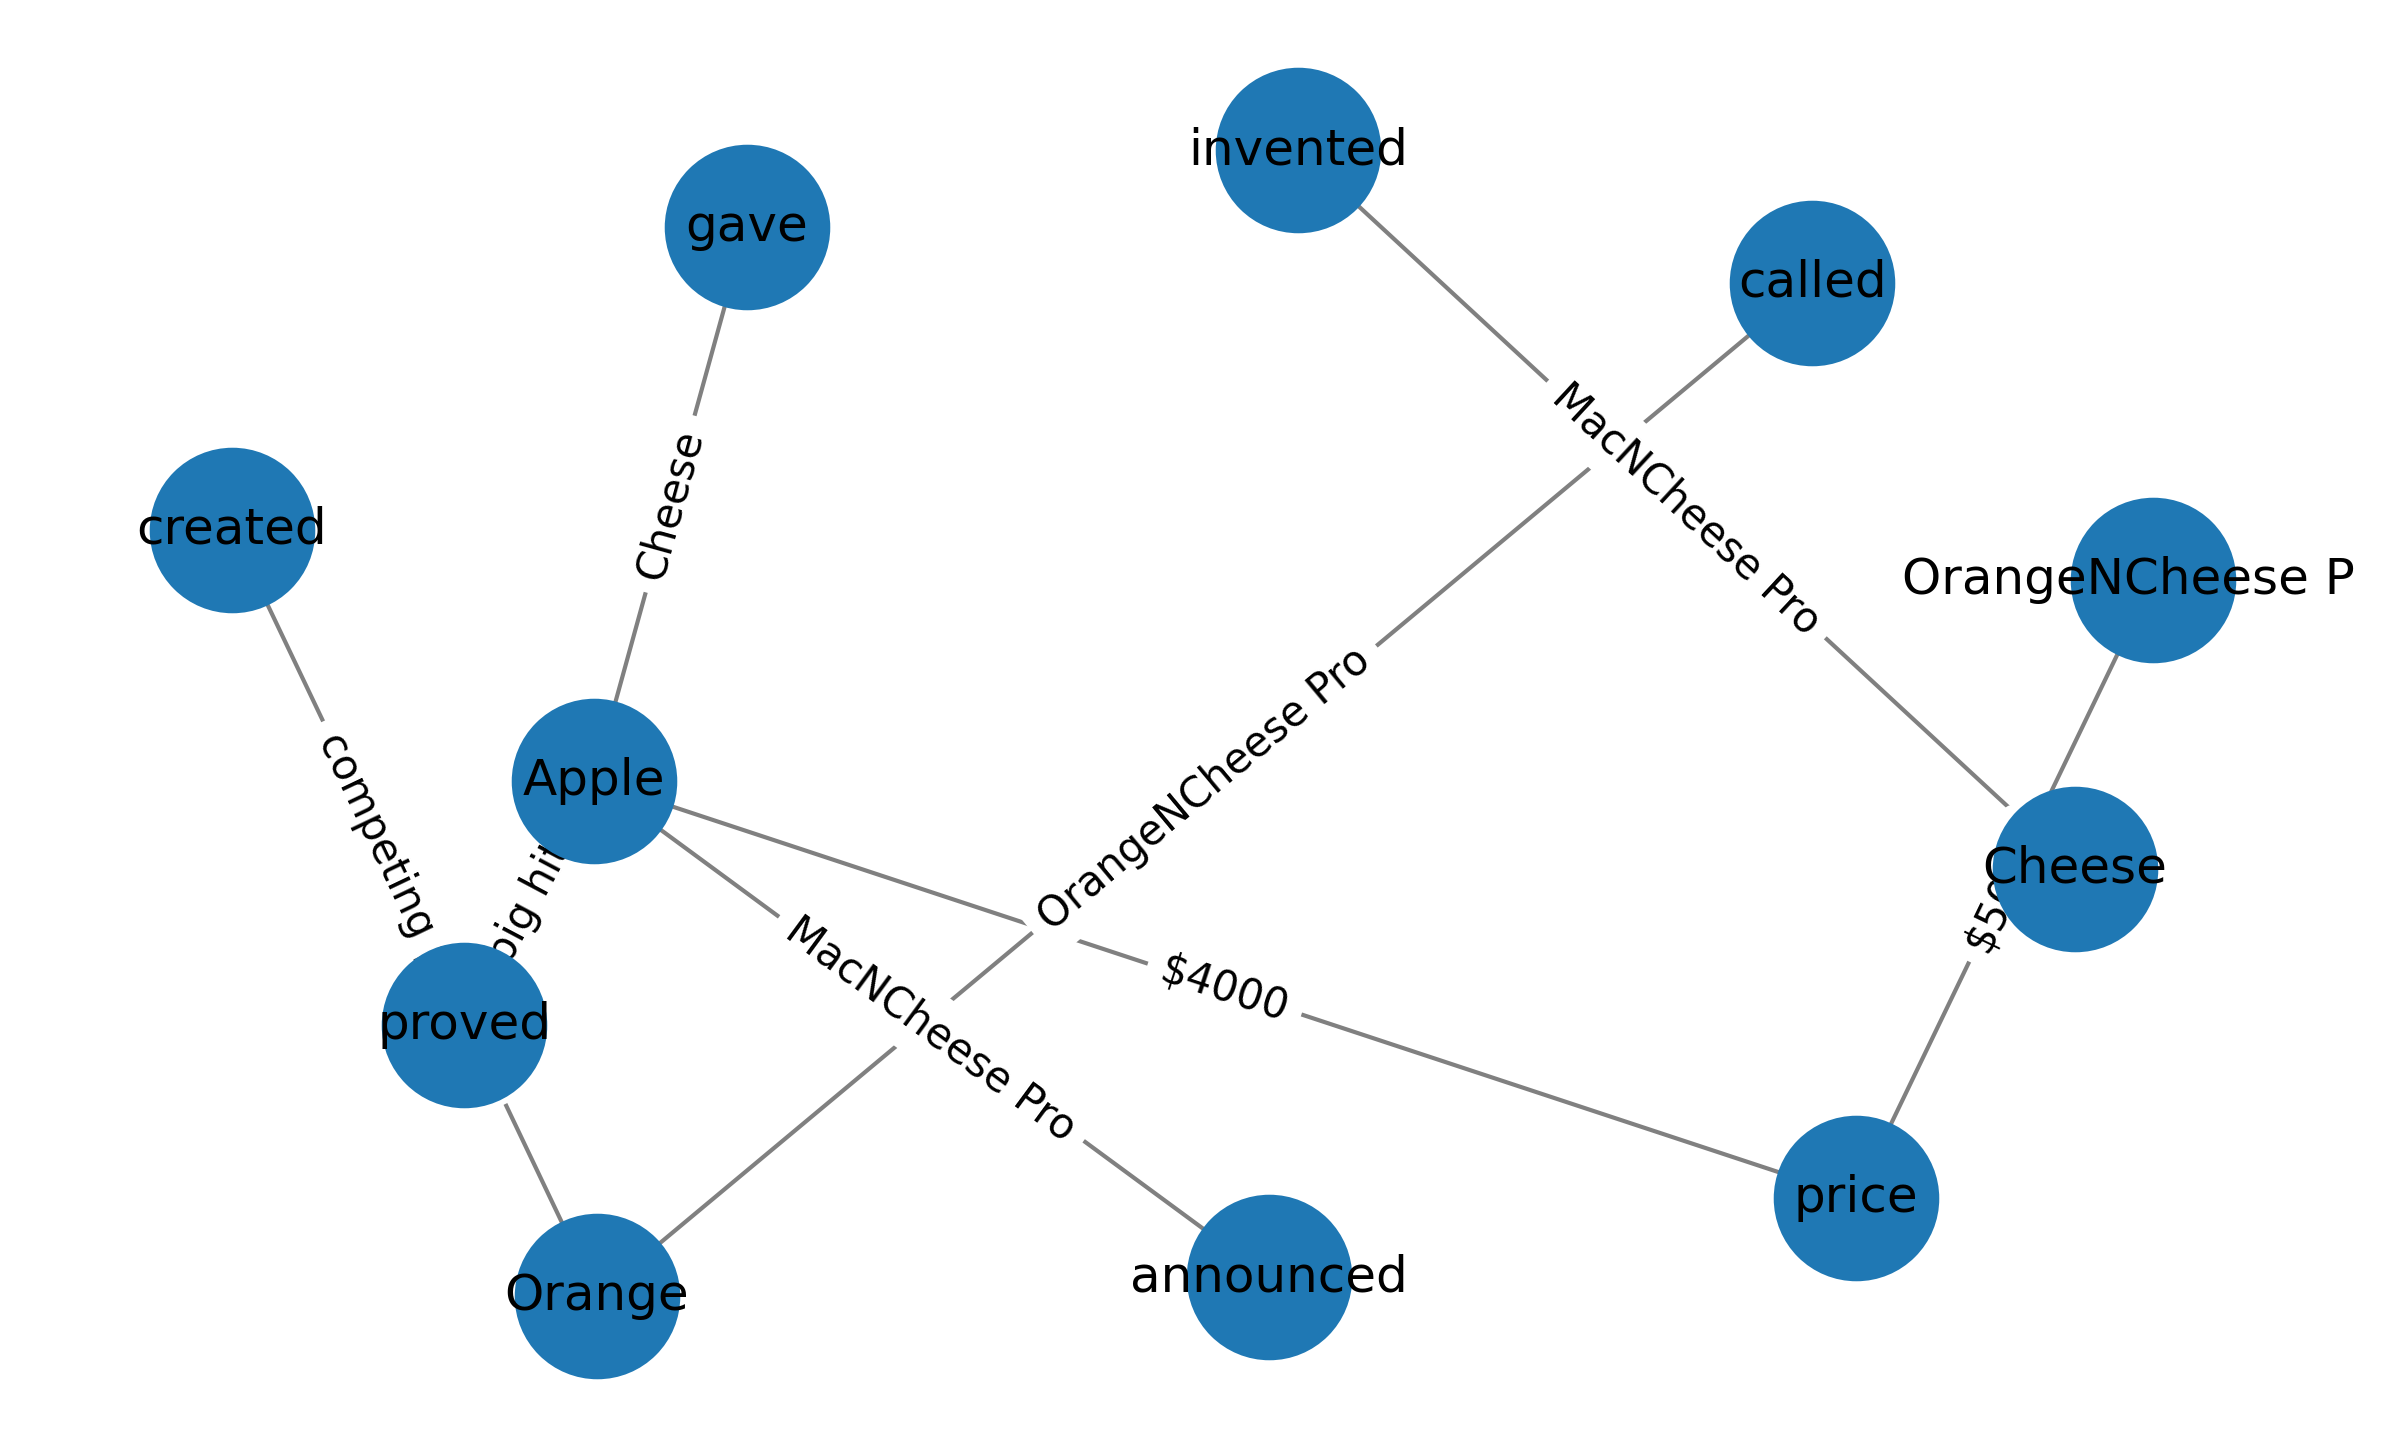

In [ ]:
plot_graph(graph.get_triples())

In [ ]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)
chain.run(question)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new GraphQAChain chain...
Entities Extracted:
 apple, MacNCheese Pro
Full Context:


> Finished chain.


"\n\nI don't know."

# Approach 3: Using only Context

In [ ]:
# langchain QA

from langchain import PromptTemplate, OpenAI, LLMChain

template = """Context: {context}

Question: {question}

Answer: Let's think step by step."""
prompt = PromptTemplate(template=template, input_variables=["context", "question"])
llm_chain = LLMChain(prompt=prompt, llm=OpenAI(temperature=0), verbose=True)

llm_chain.run({"context": context, "question": question})



> Entering new LLMChain chain...
Prompt after formatting:
Context: Apple announced the MacNCheese Pro in 2025. It proved a big hit.
Apple gave Cheese a rousing ovation in 2026 after he invented the MacNCheese Pro in 2024.
Orange created a competing product called the OrangeNCheese Pro.
It's price was slightly higher at $5000, compared to Apple's $4000.

Question: When did apple announce the MacNCheese Pro?

Answer: Let's think step by step.

> Finished chain.


' Apple announced the MacNCheese Pro in 2025.'

In [ ]:
# just using ChatGPT directly

prompt = f"Context: {context}\nQuestion: {question}"
completion = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                          temperature=0,
                                          messages=[{"role": "user",
                                                     "content": prompt}])
print("Prompt:", prompt, '\n\n')
print("ChatGPT Completion:", completion["choices"][0]["message"]["content"])

Prompt: Context: Apple announced the MacNCheese Pro in 2025. It proved a big hit.
Apple gave Cheese a rousing ovation in 2026 after he invented the MacNCheese Pro in 2024.
Orange created a competing product called the OrangeNCheese Pro.
It's price was slightly higher at $5000, compared to Apple's $4000.
Question: When did apple announce the MacNCheese Pro? 


ChatGPT Completion: Apple announced the MacNCheese Pro in 2025.


# Approach 4: Strict JSON Framework
- https://github.com/tanchongmin/strictjson

In [ ]:
def strict_output(system_prompt, user_prompt, output_format, default_category = "", output_value_only = False,
                  model = 'gpt-3.5-turbo', temperature = 0, num_tries = 2, verbose = False):
    ''' Ensures that OpenAI will always adhere to the desired output json format.
    Uses rule-based iterative feedback to ask GPT to self-correct.
    Keeps trying up to num_tries it it does not. Returns empty json if unable to after num_tries iterations.
    If output field is a list, will treat as a classification problem and output best classification category.
    Text enclosed within < > will generated by GPT accordingly'''

    # if the user input is in a list, we also process the output as a list of json
    list_input = isinstance(user_prompt, list)
    # if the output format contains dynamic elements of < or >, then add to the prompt to handle dynamic elements
    dynamic_elements = '<' in str(output_format)
    # if the output format contains list elements of [ or ], then we add to the prompt to handle lists
    list_output = '[' in str(output_format)

    # start off with no error message
    error_msg = ''

    for i in range(num_tries):

        output_format_prompt = f'''\nYou are to output the following in json format: {output_format}.
Do not put quotation marks or escape character \ in the output fields.'''

        if list_output:
            output_format_prompt += f'''\nIf output field is a list, classify output into the best element of the list.'''

        # if output_format contains dynamic elements, process it accordingly
        if dynamic_elements:
            output_format_prompt += f'''
Any text enclosed by < and > indicates you must generate content to replace it. Example input: Go to <location>, Example output: Go to the garden
Any output key containing < and > indicates you must generate the key name to replace it. Example input: {{'<location>': 'description of location'}}, Example output: {{'school': 'a place for education'}}'''

        # if input is in a list format, ask it to generate json in a list
        if list_input:
            output_format_prompt += '''\nGenerate a list of json, one json for each input element.'''

        # Use OpenAI to get a response
        response = openai.ChatCompletion.create(
          temperature = temperature,
          model=model,
          messages=[
            {"role": "system", "content": system_prompt + output_format_prompt + error_msg},
            {"role": "user", "content": str(user_prompt)}
          ]
        )

        res = response['choices'][0]['message']['content'].replace('\'', '"')

        # ensure that we don't replace away aprostophes in text
        res = re.sub(r"(\w)\"(\w)", r"\1'\2", res)

        if verbose:
            print('System prompt:', system_prompt + output_format_prompt + error_msg)
            print('\nUser prompt:', str(user_prompt))
            print('\nGPT response:', res)

        # try-catch block to ensure output format is adhered to
        try:
            output = json.loads(res)
            if isinstance(user_prompt, list):
                if not isinstance(output, list): raise Exception("Output format not in a list of json")
            else:
                output = [output]

            # check for each element in the output_list, the format is correctly adhered to
            for index in range(len(output)):
                for key in output_format.keys():
                    # unable to ensure accuracy of dynamic output header, so skip it
                    if '<' in key or '>' in key: continue
                    # if output field missing, raise an error
                    if key not in output[index]: raise Exception(f"{key} not in json output")
                    # check that one of the choices given for the list of words is an unknown
                    if isinstance(output_format[key], list):
                        choices = output_format[key]
                        # ensure output is not a list
                        if isinstance(output[index][key], list):
                            output[index][key] = output[index][key][0]
                        # output the default category (if any) if GPT is unable to identify the category
                        if output[index][key] not in choices and default_category:
                            output[index][key] = default_category
                        # if the output is a description format, get only the label
                        if ':' in output[index][key]:
                            output[index][key] = output[index][key].split(':')[0]

                # if we just want the values for the outputs
                if output_value_only:
                    output[index] = [value for value in output[index].values()]
                    # just output without the list if there is only one element
                    if len(output[index]) == 1:
                        output[index] = output[index][0]

            return output if list_input else output[0]

        except Exception as e:
            error_msg = f"\n\nResult: {res}\n\nError message: {str(e)}"
            print("An exception occurred:", str(e))
            print("Current invalid json format:", res)

    return {}

## Overall Open-ended generation
- **system_prompt**: Write in whatever you want GPT to become. "You are a \<purpose in life\>"
- **user_prompt**: The user input. Later, when we use it as a function, this is the function input
- **output_format**: JSON format with the key as the output key, and the value as the output description
    - The output keys will be preserved exactly, while GPT will generate content to match the description of the value as best as possible

#### Example Usage
```python
res = strict_output(system_prompt = 'You are a classifier',
                    user_prompt = 'It is a beautiful day',
                    output_format = {"Sentiment": "Type of Sentiment",
                                    "Tense": "Type of Tense"})
                                    
print(res)
```

#### Example output
```{'Sentiment': 'Positive', 'Tense': 'Present'}```


## Step 1: Generate knowledge graph from context

In [ ]:
res = strict_output(system_prompt = '''You are a knowledge graph builder.
You are to output relations between two objects in the form [object_1, relation, object_2].
All information about dates must be included.
Example Input: John bought a laptop
Example Output: [['John', 'bought', 'laptop']]
Example Input: John built a house in 2019
Example Output: [['John', 'built', 'house'], ['house', 'built in', '2019']]''',
                    user_prompt = context,
                    output_format = {"Knowledge Graph": "List of relations of the form [object_1, relation, object_2]"})
print(res)

{'Knowledge Graph': [['Apple', 'announced', 'MacNCheese Pro'], ['MacNCheese Pro', 'announced in', '2025'], ['Apple', 'proved', 'big hit'], ['Apple', 'gave', 'Cheese'], ['Cheese', 'rousing ovation in', '2026'], ['Cheese', 'invented', 'MacNCheese Pro'], ['MacNCheese Pro', 'invented in', '2024'], ['Orange', 'created', 'OrangeNCheese Pro'], ['OrangeNCheese Pro', 'price', '$5000'], ['Apple', 'price', '$4000']]}


In [ ]:
kg = res['Knowledge Graph']

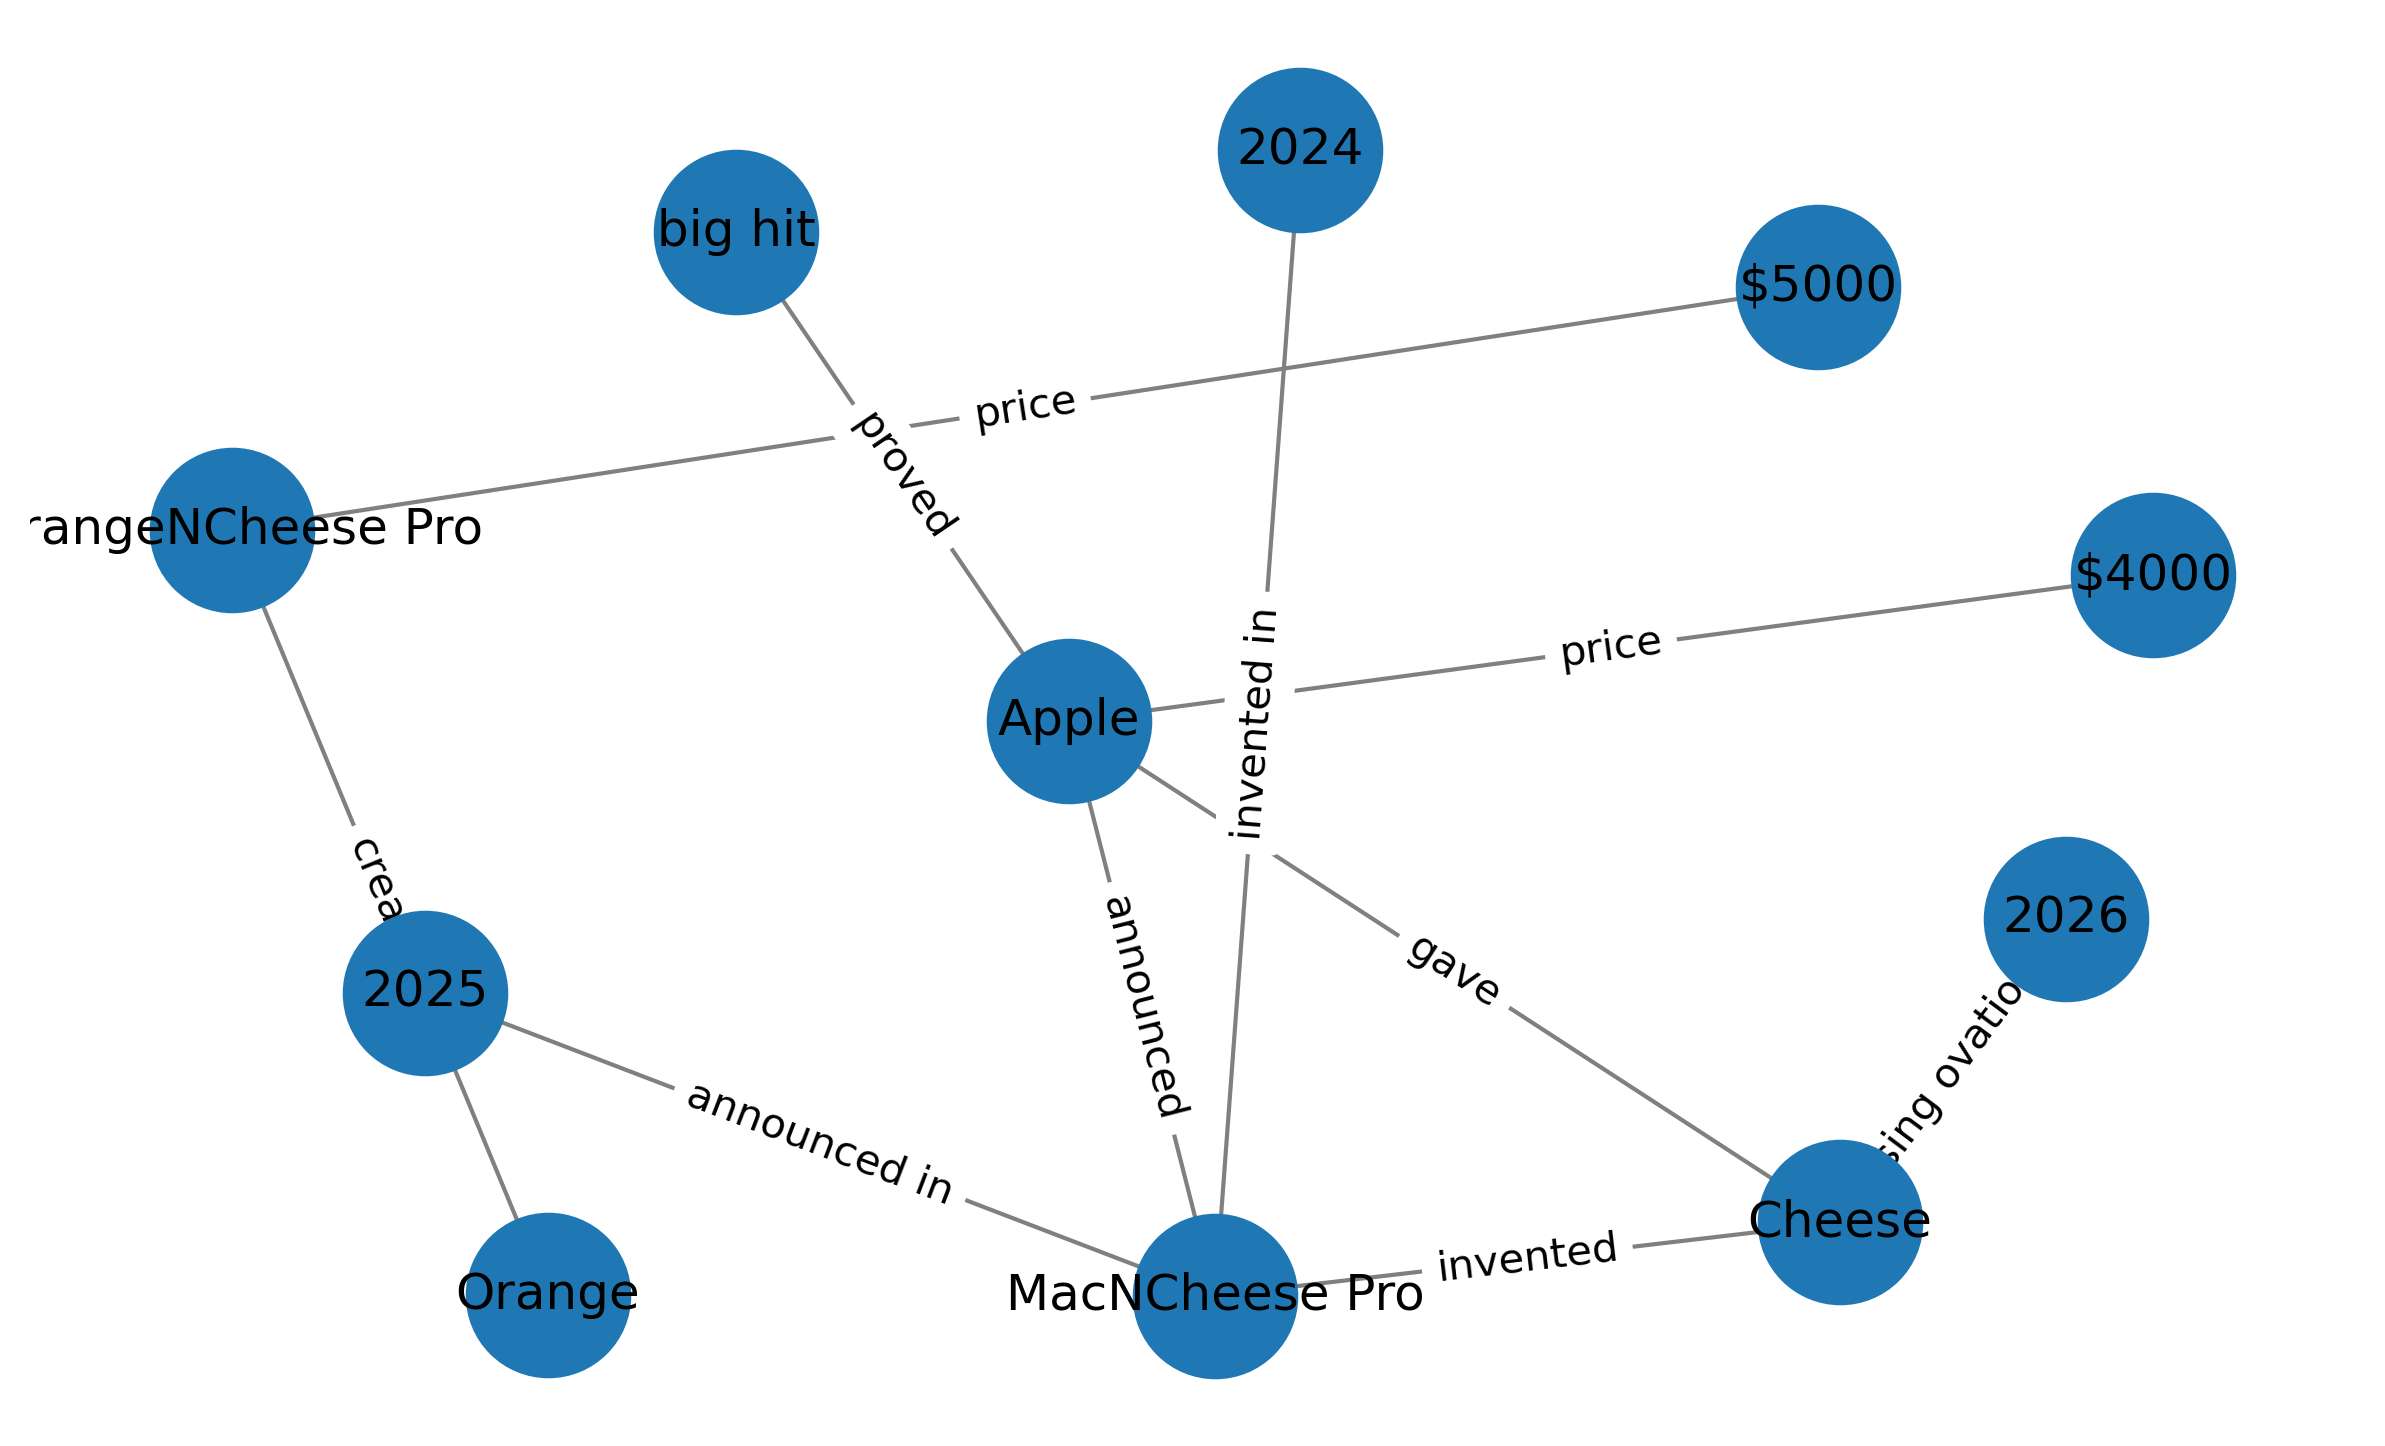

In [ ]:
plot_graph(kg)

# Step 2: Parse Knowledge Graph

In [ ]:
res = strict_output(system_prompt = f'''You are a knowledge graph parser.
Only output the relations that are relevant to the question.
Knowledge graph: {kg}''',
                    user_prompt = f'''Question: {question}''',
                    output_format = {"Parsed Knowledge Graph": "List of relations of the form [object1, relation, object2]"})
print(res)

{'Parsed Knowledge Graph': [['Apple', 'announced', 'MacNCheese Pro'], ['MacNCheese Pro', 'announced in', '2025']]}


In [ ]:
parsed_kg = res['Parsed Knowledge Graph']

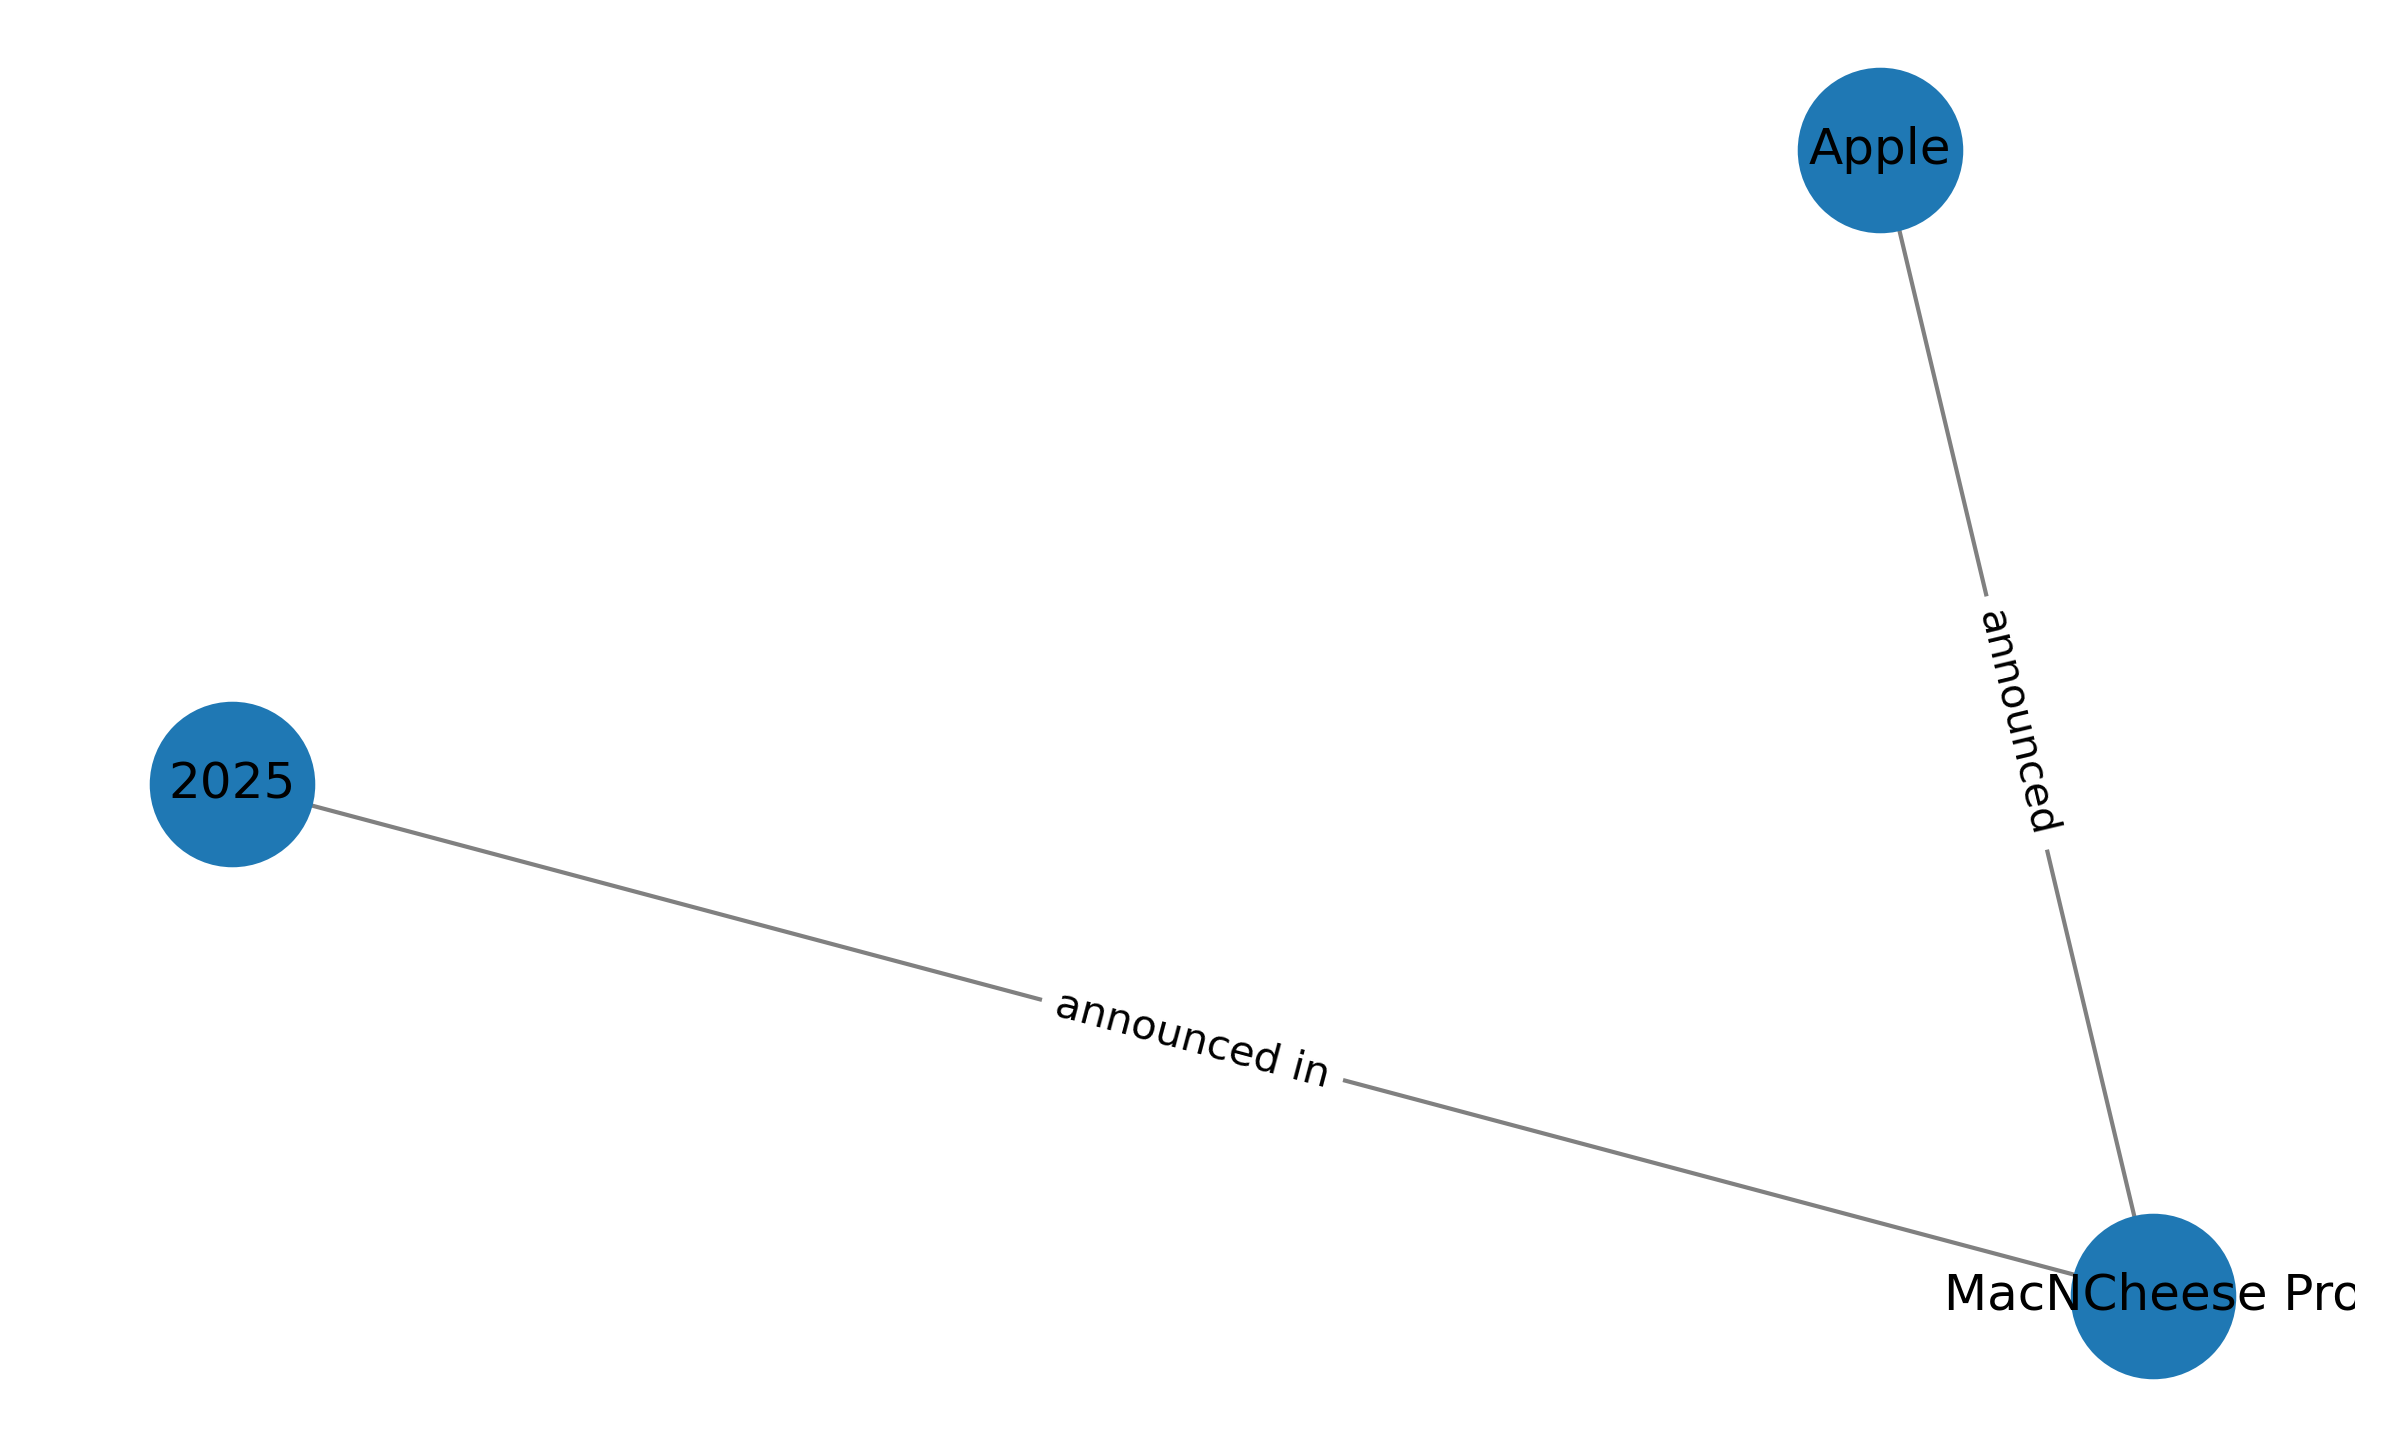

In [ ]:
plot_graph(parsed_kg)

# Step 3: Use Parsed Knowledge Graph to Answer Question

In [ ]:
res = strict_output(system_prompt = f'''Use the knowledge graph to answer the following question.
If you are unsure, output 'No Info'
Knowledge Graph: {parsed_kg}''',
                    user_prompt = f'''Question: {question}''',
                    output_format = {"Answer": "Answer question using knowledge graph"})
print('Question:', question)
print('Answer:', res['Answer'])

Question: When did apple announce the MacNCheese Pro?
Answer: 2025
